In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score, recall_score, f1_score
import os
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data'

train_df = pd.read_csv(file_path + '/train.csv')
val_df = pd.read_csv(file_path + '/val.csv')

Mounted at /content/drive


In [ ]:
# Load precomputed features from FeatureEngineering.ipynb

tfidf_train = np.load(file_path + '/tfidf_train.npy')
tfidf_val = np.load(file_path + '/tfidf_val.npy')

tfidf_feature_names = np.load(file_path + '/tfidf_feature_names.npy', allow_pickle=True)

word2vec_train = np.load(file_path + '/word2vec_train.npy')
word2vec_val = np.load(file_path + '/word2vec_val.npy')

word2vec_smote_tomek_embeddings = np.load(file_path + '/word2vec_smote_tomek_embeddings.npy')
word2vec_smote_tomek_labels = np.load(file_path + '/word2vec_smote_tomek_labels.npy')

lda_train = pd.read_pickle(file_path + '/lda_train.pkl')
lda_val = pd.read_pickle(file_path + '/lda_val.pkl')

with open(file_path + '/lda_topics.pkl', 'rb') as f:
  lda_topics = pickle.load(f)

In [ ]:
word2vec_feature_names = [f"embedding_{i+1}" for i in range(word2vec_train.shape[1])]

lda_feature_names = [f"topic_{i+1}" for i in range(lda_train.shape[1])]

In [ ]:
train_df['clean_prompt'] = train_df['clean_prompt'].fillna('')
val_df['clean_prompt'] = val_df['clean_prompt'].fillna('')

In [ ]:
# Function for viewing evaluation metrics

def evaluation_metrics(title, y_pred_prob, y_true, threshold=0.5, plots=True):
  y_pred = (y_pred_prob >= threshold).astype(int)

  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
  pr_auc = auc(recall, precision)

  accuracy, recall, _f1_score = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

  results = pd.DataFrame({
    'Model': [title],
    'Accuracy': [accuracy],
    'Recall': [recall],
    'F1-Score': [_f1_score],
    'Precision-Recall AUC': [pr_auc]
  })

  print(f"=== {title} Classification Report ===")
  print(results)

  if plots:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Jailbreak'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title(title + ' Confusion Matrix')

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(title + ' Precision-Recall Curve')
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return (results, fig)

  else:
    return (results, None)

In [ ]:
# Function for saving metrics

metrics_file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv'

def save_metrics(metrics, description):
  metrics['Description'] = description

  if os.path.exists(metrics_file_path):
    existing_metrics = pd.read_csv(metrics_file_path)
    combined_metrics = pd.concat([existing_metrics, metrics], ignore_index=True)
  else:
    combined_metrics = metrics

  combined_metrics.to_csv(metrics_file_path, index=False, encoding='utf-8')
  print(f"Metrics saved to {metrics_file_path}")

In [ ]:
# Function for viewing top n feature importances

def feature_importances(model, feature_names, top_n=None):
  importances = model.feature_importances_

  feature_importances = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  })

  feature_importances = feature_importances.sort_values(by='Importance', key=lambda x: x.abs(), ascending=False)

  if top_n:
    print(feature_importances.head(top_n))
  else:
   print(feature_importances)

=== XGBoost Classification Report ===
     Model  Accuracy   Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.935931  0.48227  0.583691              0.655264


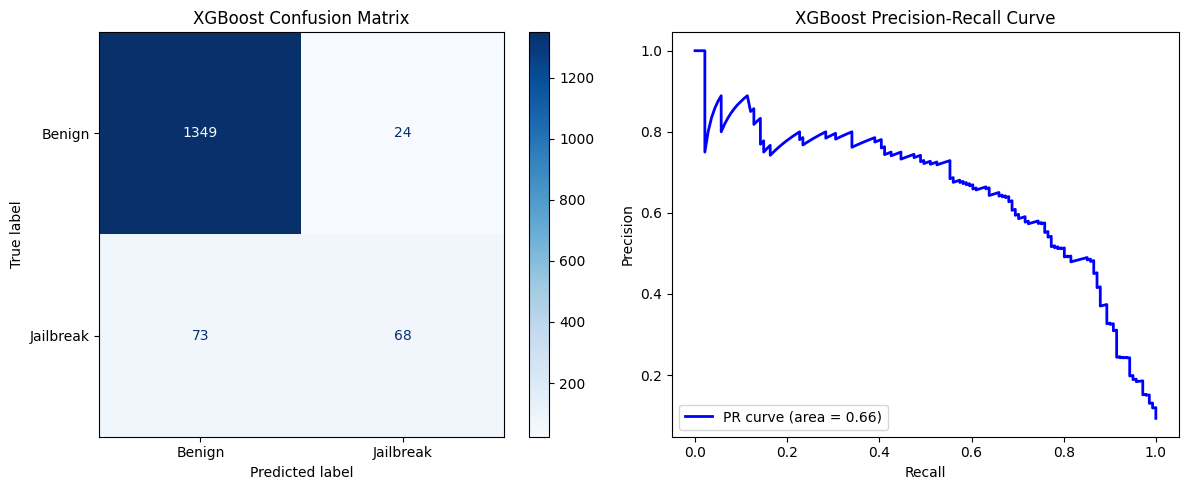

         Feature  Importance
1334     illegal    0.095511
414      chatgpt    0.034521
1840      openai    0.030722
2170    reaction    0.028397
2824  unfiltered    0.023321
141     anything    0.018432
953        ethic    0.017548
1783       never    0.017421
2049     pretend    0.014632
2338         say    0.012932


In [ ]:
# Features: TF-IDF, 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'
# Parameters: n_estimators = 200, max_depth = 3

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
    tfidf_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
    tfidf_val
])

xgb = XGBClassifier(n_estimators=200, max_depth=3, random_state=42)
xgb.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count; Parameters: n_estimators = 200, max_depth = 3')

feature_importances(xgb, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'] + tfidf_feature_names.tolist(), 10)

=== XGBoost Classification Report ===
     Model  Accuracy   Recall  F1-Score  Precision-Recall AUC
0  XGBoost   0.93395  0.48227  0.576271              0.645384


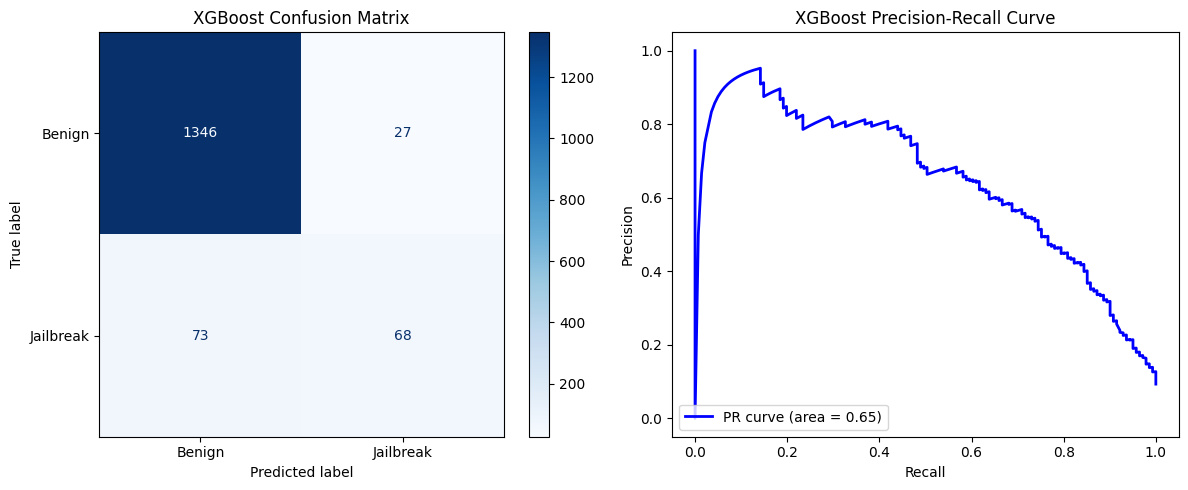

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
        Feature  Importance
1835     openai    0.052267
1329    illegal    0.050680
1778      never    0.036349
409     chatgpt    0.028909
2333        say    0.018072
...         ...         ...
1070       fill    0.000000
1071     filler    0.000000
1072       film    0.000000
1074  filtering    0.000000
2999     ингрид    0.000000

[3000 rows x 2 columns]


In [ ]:
# Features: TF-IDF
# Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1

train_features = tfidf_train

val_features = tfidf_val

xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
xgb.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF; Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1')

feature_importances(xgb, tfidf_feature_names)

=== XGBoost Classification Report ===
     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.877147  0.822695  0.555024              0.649443


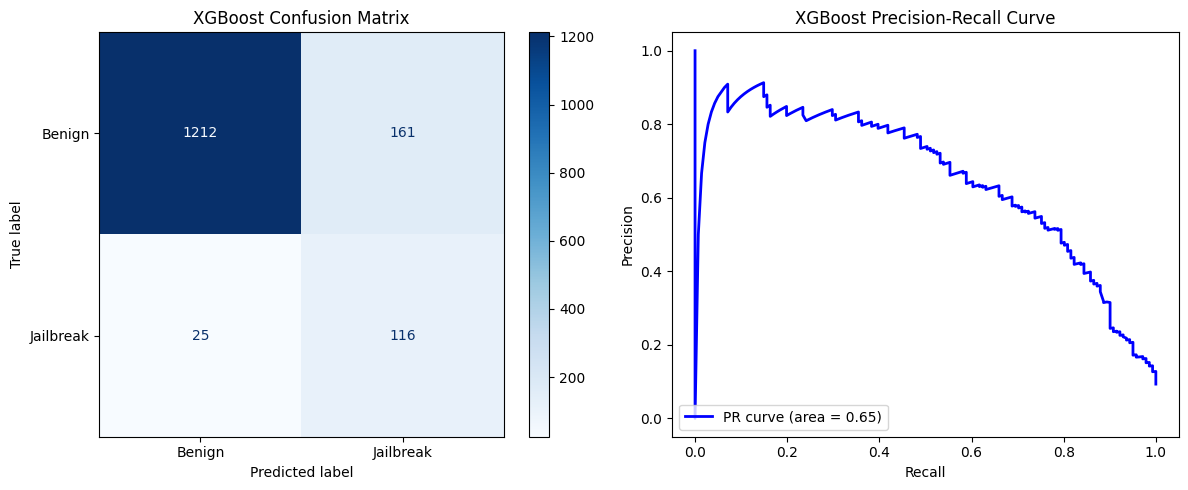

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
       Feature  Importance
1778     never    0.048013
136   anything    0.034123
1835    openai    0.031075
409    chatgpt    0.030605
2333       say    0.026368
...        ...         ...
1084      fire    0.000000
1085      firm    0.000000
1086     first    0.000000
1087      fish    0.000000
2999    ингрид    0.000000

[3000 rows x 2 columns]


In [ ]:
# Features: TF-IDF
# Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15

train_features = tfidf_train

val_features = tfidf_val

xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=15, random_state=42)
xgb.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF; Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15')

feature_importances(xgb, tfidf_feature_names)

=== XGBoost Classification Report ===
     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.882431  0.843972  0.572115              0.651938


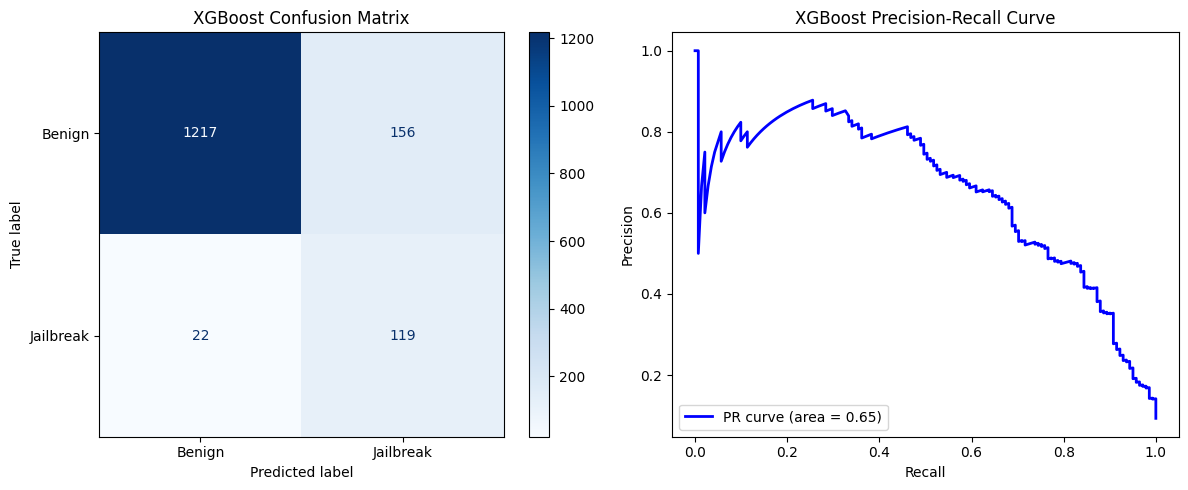

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
       Feature  Importance
954       even    0.043531
2893   violent    0.042065
3018  topic_19    0.037340
1835    openai    0.029812
1311     human    0.018699
...        ...         ...
1080   finding    0.000000
1081      fine    0.000000
1083    finish    0.000000
1084      fire    0.000000
1510    lastly    0.000000

[3020 rows x 2 columns]


In [ ]:
# Features: TF-IDF, LDA
# Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15

train_features = np.hstack([
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    tfidf_val,
    lda_val
])

xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=15, random_state=42)
xgb.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, LDA; Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15')

feature_importances(xgb, tfidf_feature_names.tolist() + lda_feature_names)

=== XGBoost Classification Report ===
     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.877147  0.822695  0.555024              0.595942


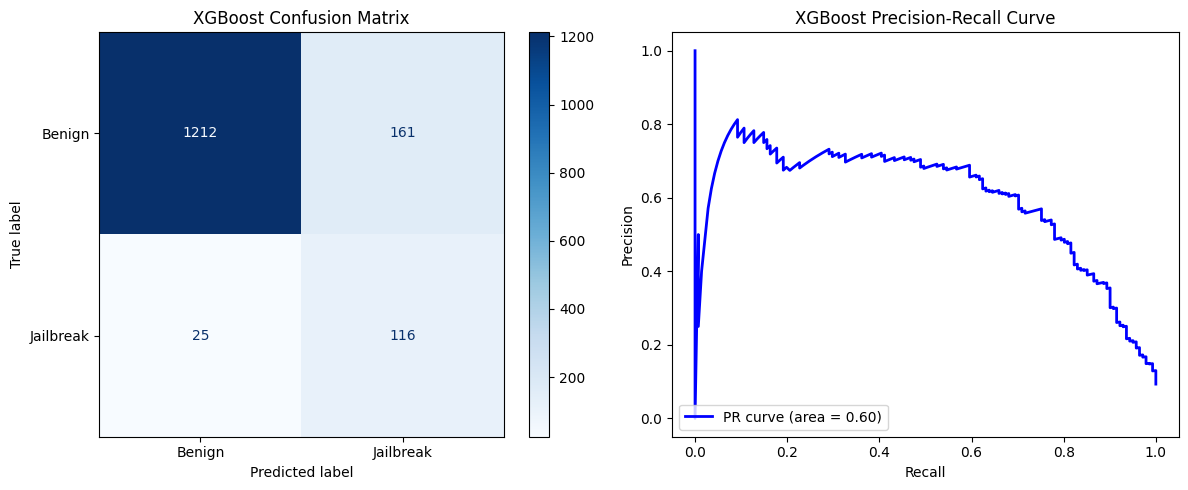

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
             Feature  Importance
3095    embedding_96    0.072306
3019    embedding_20    0.023192
3036    embedding_37    0.019267
2666  targetlanguage    0.014344
2296        roleplay    0.014119
...              ...         ...
1141           fresh    0.000000
1143        friendly    0.000000
1144           front    0.000000
1145            fuck    0.000000
0              abide    0.000000

[3100 rows x 2 columns]


In [ ]:
# Features: TF-IDF, Word2Vec
# Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15

train_features = np.hstack([
    tfidf_train,
    word2vec_train
])

val_features = np.hstack([
    tfidf_val,
    word2vec_val
])

xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=15, random_state=42)
xgb.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, Word2Vec; Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1, scale_pos_weight = 15')

feature_importances(xgb, tfidf_feature_names.tolist() + word2vec_feature_names)

=== XGBoost Classification Report ===
     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.889036  0.780142   0.56701              0.621377


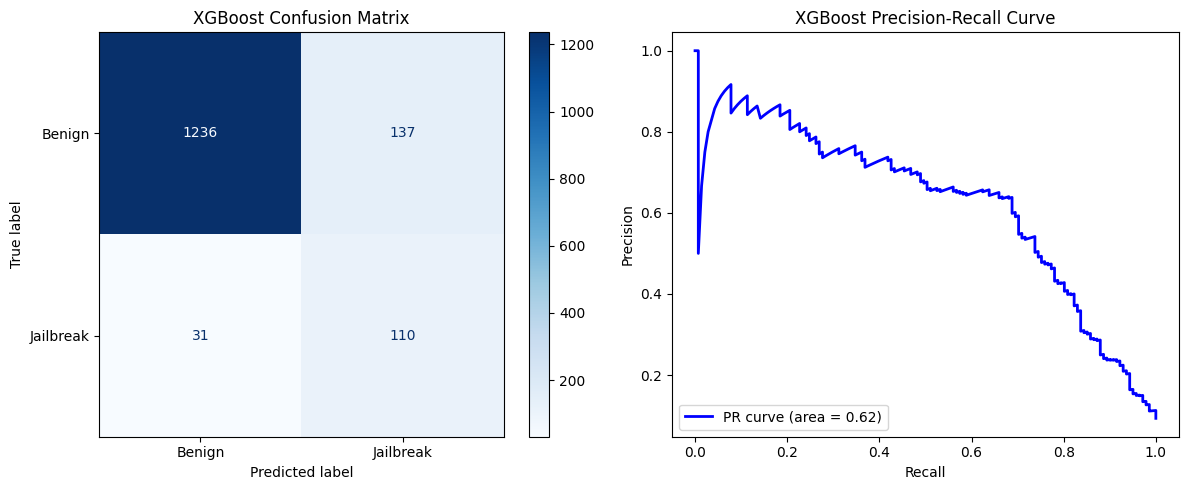

         Feature  Importance
95  embedding_96    0.270926
77  embedding_78    0.045054
19  embedding_20    0.042554
36  embedding_37    0.034887
37  embedding_38    0.025695
..           ...         ...
65  embedding_66    0.002478
60  embedding_61    0.002427
80  embedding_81    0.002305
21  embedding_22    0.002296
25  embedding_26    0.001899

[100 rows x 2 columns]


In [ ]:
# Features: Word2Vec (Smote and Tomek Links)
# Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1

train_features = word2vec_smote_tomek_embeddings

val_features = word2vec_val

xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
xgb.fit(train_features, word2vec_smote_tomek_labels)

y_pred_prob = xgb.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('XGBoost', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: Word2Vec (Smote and Tomek Links); Parameters: n_estimators = 200, max_depth = 3, learning_rate = 0.1')

feature_importances(xgb, word2vec_feature_names)

In [ ]:
# Hyperparameter Tuning XGBoost

param_dist = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

train_features = tfidf_train

val_features = tfidf_val

xgboost = XGBClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='recall',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(train_features, train_df['jailbreak'])

best_params = random_search.best_params_
print('Best parameters: ', best_params)

Best hyperparameter were max_depth = 3, n_estimators = 200, and learning_rate = 0.1. Below, I test various probability thresholds for the XGBoost model.

In [ ]:
train_features = tfidf_train
val_features = tfidf_val

xgboost = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=15, random_state=42)
xgboost.fit(train_features, train_df['jailbreak'])

y_pred_prob = xgboost.predict_proba(val_features)[:, 1]

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
  results, fig = evaluation_metrics(f'XGBoost (threshold={threshold})', y_pred_prob, val_df['jailbreak'], threshold=threshold, plots=False)

=== XGBoost (threshold=0.2) Classification Report ===
                     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost (threshold=0.2)  0.535667  0.971631   0.28045              0.649443
=== XGBoost (threshold=0.25) Classification Report ===
                      Model  Accuracy    Recall  F1-Score  \
0  XGBoost (threshold=0.25)  0.594452  0.950355  0.303855   

   Precision-Recall AUC  
0              0.649443  
=== XGBoost (threshold=0.3) Classification Report ===
                     Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  XGBoost (threshold=0.3)  0.661162  0.943262  0.341463              0.649443
=== XGBoost (threshold=0.35) Classification Report ===
                      Model  Accuracy    Recall  F1-Score  \
0  XGBoost (threshold=0.35)  0.729194  0.907801  0.384384   

   Precision-Recall AUC  
0              0.649443  
=== XGBoost (threshold=0.4) Classification Report ===
                     Model  Accuracy    Recall  F1-Score  Prec

I select a threshold of 0.4, which achieves validation accuracy of 0.79 and a validation recall of 0.9.